**IMPROVEMENT ON PYTORCH MODEL**

The following are the improvements carried out on the pytorch model that was built by Dev:
(1) I first improve model performance by adjusting the following:
(a) amplitude of max logarithm
(b) number of layers
(c) embedded dropping
(2) I included more features such as adjusted populations and sum of asset exposure as adopted by xavier.
In conclusion, the model seems to maintain the performance level even though more features were added, this is know by a look at the loss vs learning_rate curve.

In [0]:
from fastai.tabular import *

In [0]:
train_df = pd.read_csv('OUTPUT_WBI_exposer_cyclones_v10.csv')

In [0]:
train_df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
SID,1949163N07145,1950241N23140,1951224N12316,1951337N09150,1952180N05144
NAME,DELLA,JANE,CHARLIE,AMY,EMMA
ISO,JPN,JPN,JAM,PHL,PHL
YEAR,1949,1950,1951,1951,1952
BASIN,WP,WP,NAm,WP,WP
SUB BASIN,WP,WP,CS,WP,WP
NATURE,TS,ET,TS,TS,TS
ISO_TIME,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","['1951-08-17 21:00:00', '1951-08-18 12:00:00']","['1951-12-08 18:00:00', '1951-12-08 21:00:00',...","['1952-07-01 18:00:00', '1952-07-01 21:00:00',..."
COORDS,"[[35.67, 130.99], [38.35, 135.07], [38.82, 136...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]","[[17.34, -75.41], [18.3, -79.4]]","[[11.52, 127.35], [11.34, 127.09], [11.17, 126...","[[9.57, 127.79], [9.63, 127.19], [12.38, 119.4..."


In [0]:
#adopted from xavier tores's codes
train_df['CALC_assets_emdat'] = train_df['34KN_ASSETS'] + train_df['64KN_ASSETS'] + train_df['96KN_ASSETS']
df_mod = train_df.drop(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'DAY_HRS', 'NIGHT_HRS', 'in_wbi',
                 '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP', '96KN_ASSETS'], 
                 axis = 1)

In [0]:
# Adding month per Vamsi's code in SVM folder
df_mod['Month'] = df_mod.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

In [0]:
# Using Xavier's CPI logic...
df_mod["TOTAL_DAMAGE_(000$)_Adjusted"]= df_mod["TOTAL_DAMAGE_(000$)"] / df_mod["CPI"]
df_mod["TOTAL_DAMAGE_(000$)_Adjusted"]= df_mod["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
df_mod = df_mod.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)


In [0]:
df_mod.isna().sum()

Unnamed: 0                                               0
BASIN                                                    0
SUB BASIN                                                0
NATURE                                                   0
ISO_TIME                                                 0
TOTAL_HRS                                                0
USA_SSHS                                                 0
WIND_CALC_MEAN                                           4
PRES_CALC_MEAN                                           0
STORM_SPD_MEAN                                           0
STORM_DR_MEAN                                            0
V_LAND_KN                                                0
TOTAL_DEATHS                                           134
Air transport, freight (million ton-km)                159
Arable land (hectares per person)                        1
Cereal yield (kg per hectare)                           10
Food production index (2004-2006 = 100)                 

In [0]:
dep_var = 'TOTAL_AFFECTED'

cat_names = ['BASIN', 
             'SUB BASIN', 
             'NATURE', 
             'Income_level_Final', 
             'USA_SSHS',
             'Month']

cont_names = ['TOTAL_HRS',
             'CALC_assets_emdat',
              'pop_max_34_adj',
              'pop_max_50_adj',
              'pop_max_64_adj', 
              'PRES_CALC_MEAN', 
              'STORM_SPD_MEAN', 
              'STORM_DR_MEAN',
              'Mobile cellular subscriptions (per 100 people)',
              'Population density (people per sq. km of land area)',
              'V_LAND_KN',
              'Arable land (hectares per person)',
              'GDP per capita (constant 2010 US$)',
              'Air transport, freight (million ton-km)',
              'Cereal yield (kg per hectare)',
              'Food production index (2004-2006 = 100)',
              'GDP growth (annual %)',
              'Life expectancy at birth, total (years)',
              'Adjusted savings: education expenditure (% of GNI)',
              'Rural population (% of total population)']

#Features not used:
# WIND_CALC_MEAN
# 34KN_POP
# 34KN_ASSETS
# 64KN_POP
# 64KN_ASSETS
# 96KN_POP
# 96KN_ASSETS
# Net flows from UN agencies US$
# pop_max_34                                              
# pop_max_50                                              
# pop_max_64                                              
# Total Deaths

In [0]:
#FillMissing populates the NA values with Medians. Categorify converts categorical variables 
# into category data types and Normalise normalises the continous variables.
procs=[FillMissing, Categorify, Normalize]

In [0]:
#Helper function to generate a DataBunch from a dataframe, taking into account parameters
#log = True enables logs to be used for target variable (Total Affected)
data = (TabularList.from_df(df_mod, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_rand_pct()
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .databunch())

In [0]:
data.show_batch(10)

BASIN,SUB BASIN,NATURE,Income_level_Final,USA_SSHS,Month,CALC_assets_emdat_na,pop_max_34_adj_na,pop_max_50_adj_na,pop_max_64_adj_na,Mobile cellular subscriptions (per 100 people)_na,Arable land (hectares per person)_na,GDP per capita (constant 2010 US$)_na,"Air transport, freight (million ton-km)_na",Cereal yield (kg per hectare)_na,Food production index (2004-2006 = 100)_na,GDP growth (annual %)_na,"Life expectancy at birth, total (years)_na",Adjusted savings: education expenditure (% of GNI)_na,TOTAL_HRS,CALC_assets_emdat,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),V_LAND_KN,Arable land (hectares per person),GDP per capita (constant 2010 US$),"Air transport, freight (million ton-km)",Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP growth (annual %),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),target
WP,WP,TS,High_Middle,1,8,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.1531,2.7866,-0.1472,0.2085,0.0654,-0.2528,-0.1745,0.7811,1.0396,-0.1736,0.4947,-0.2871,-0.2176,2.2556,1.4807,1.3232,0.5719,0.7414,-0.7620,-0.1290,5.9401712
WP,WP,TS,Low_Middle,4,9,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0561,-0.1946,-0.4826,-0.4684,-0.4476,-0.6510,-0.1312,0.7604,-0.9023,-0.1975,1.9593,-0.1740,-0.5757,-0.4596,-1.2234,-2.0235,-0.1858,-1.0575,-0.2584,0.8941,11.885867
WP,WP,TS,Low_Middle,1,5,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.9592,-0.1628,0.3604,-0.2446,-0.3306,0.0272,-0.4039,0.7096,0.1291,-0.0372,0.2218,-0.3599,-0.5332,-0.4188,-0.1346,0.2370,0.1709,-0.2015,-0.7152,0.3196,10.645425
EP,EP,TS,High_Middle,0,10,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0561,-0.4200,-0.5813,-0.4690,-0.4963,0.4460,-0.2527,-1.6722,0.1867,-0.2569,-1.6913,0.0509,-0.0078,-0.3999,-0.1152,0.2538,-0.0096,0.6524,0.7473,-1.0882,9.903487
WP,WP,TS,Low_Middle,2,10,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.9592,-0.4004,-0.6008,-0.3188,-0.4988,-0.3715,-0.7296,0.8204,-0.9023,-0.1314,0.4884,-0.2667,-0.5650,-0.4298,-0.9278,-1.2540,-0.0538,-0.7714,-0.7048,0.3846,11.2769375
NAm,GM,TS,High,0,10,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0561,-0.3622,1.1681,-0.0577,0.2384,-0.1454,1.0197,-1.8467,1.8258,-0.2748,1.5704,0.7186,3.0770,5.4367,2.6276,0.7650,-0.3878,1.1229,0.5985,-1.3444,8.517193
WP,WP,TS,Low_Middle,-1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,0.6531,-0.2644,-0.3683,-0.3848,-0.3408,0.1857,-0.4430,-0.3092,-0.9023,-0.1910,0.5982,-0.1908,-0.5715,-0.4575,-1.3343,-1.9938,0.2201,-1.0508,-0.5457,0.8472,3.3322046
SP,SP,TS,Low_Middle,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0561,-0.4179,-0.6123,-0.4995,-0.4854,-0.1361,-0.4986,-0.6316,-0.9023,-0.2750,0.1904,-0.1338,-0.4537,-0.4622,-0.7956,-0.0669,0.4331,-0.9079,1.1689,0.6697,8.4553175
NI,BB,TS,Low_Middle,1,11,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0561,-0.3541,0.1998,-0.1315,0.0350,0.2495,-1.0156,0.7420,0.5609,0.0877,-0.5466,-0.1955,-0.5560,-0.2246,-0.2600,1.4270,0.4467,-0.3848,-0.0906,0.9384,10.596635
WP,WP,TS,Low_Middle,0,7,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.5561,-0.3268,0.1562,-0.3206,-0.2729,0.2181,0.2477,0.7303,-0.8319,-0.0641,-0.6532,-0.3047,-0.6004,-0.4400,0.6542,-0.1275,0.5704,0.4212,0.0890,1.2070,8.520786


In [0]:
#Provides an upperbound for target variable
max_log_y = np.log(np.max(df_mod[dep_var])*2)
y_range = torch.tensor([0.02, max_log_y], device=defaults.device)


In [0]:
# creates a learner with embeddings
learn = tabular_learner(data, layers=[2000,400], loss_func = MSELossFlat(),
                        y_range=y_range, metrics=exp_rmspe, ps=[0.001,0.01], emb_drop=0.06)

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 5)
    (1): Embedding(13, 7)
    (2): Embedding(7, 5)
    (3): Embedding(5, 4)
    (4): Embedding(12, 6)
    (5): Embedding(13, 7)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.06, inplace=False)
  (bn_cont): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=93, out_features=2000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=2000, out_features=400, bias=True)
    (5): ReLU(inplace=Tr

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


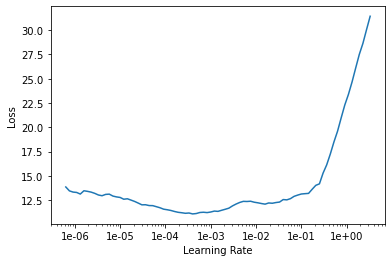

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit(10, 1e-05)

epoch,train_loss,valid_loss,exp_rmspe,time
0,11.210995,12.658268,230.432404,00:00
1,10.179010,11.742494,184.634369,00:00
2,9.579067,10.969876,157.629745,00:00
3,9.075782,9.958979,141.922638,00:00
4,8.646547,8.745667,138.519470,00:00
5,8.292824,9.041924,113.315620,00:00
6,8.084898,8.840598,124.444283,00:00
7,7.809465,8.722465,203.220551,00:00
8,7.614501,8.681787,172.400284,00:00
9,7.377949,8.546072,122.215469,00:00
